In [263]:
import pandas as pd
import bz2
import json
import re
import math
import pickle
import string
import statistics as stat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from langdetect import detect


from empath import Empath #pip install empath

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
import spacy, sklearn
from spacy.lang.en import English

nltk.download('punkt')
nltk.download('stopwords')#redundancy, remove ?
nltk.download('wordnet')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulmoreau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [264]:
Path = "../data/Pope-quotes.pkl"
file = open(Path,'rb')
df_initial = pickle.load(file)


In [265]:
def extract_features(df):

    features_nbr_words = pd.DataFrame([extract_stats(df['nbr_words'])],columns=['mean_nbr_words','median_nbr_words','std_nbr_words'])
    features_nbr_chars = pd.DataFrame([extract_stats(df['nbr_characters'])],columns=['mean_nbr_characters','median_nbr_characters','std_nbr_characters'])
    features_nbr_occurences = pd.DataFrame([extract_stats(df['nbr_occurences'])],columns=['mean_nbr_occurences','median_nbr_occurences','std_nbr_occurences'])
    #ATTENTION -> nbr_occurences, don't put the mean because it's a power law
    
    feature_voc = extract_voc_richness(df)
    
    features_lexical_fiels = extract_lexical_fields(quotes_concatenation(df))
    
    features = pd.concat([features_nbr_words, features_nbr_chars, features_nbr_occurences, feature_voc, features_lexical_fiels], axis=1)
    
    return features

# features.rename(index={0: "Pope Francis"})


In [266]:
def extract_stats(c):
    # input: c = column of a DataFrame to be analyzed
    # output: mean, median, std of the distribution
    
    c_stats = c.describe()
    #df_stats = pd.DataFrame([c_stats.loc['mean'], c_stats.loc['50%'], c_stats.loc['std']], columns=['mean', 'b', 'c'])
    
    #mean_ = c_stats.loc['mean']
    #median_ = c_stats.loc['50%']
    #std_ = c_stats.loc['std']
    
    return c_stats.loc['mean'], c_stats.loc['50%'], c_stats.loc['std']


In [267]:
def extract_all_words(df):
    
    #words = pd.DataFrame(np.concatenate(pd.concat([df['tokenized_quote']], axis = 0)), columns=['word'])
    words = pd.DataFrame(df['tokenized_quote'].explode(ignore_index=True)).rename({'tokenized_quote': 'word'}, axis=1)

    return words

In [268]:
def extract_voc_richness(df):
    
    # input : df = DataFrame of the speaker
    # output : score = float representing the richness of vocabulary of the speaker 
    # (number of unique words, normalized with the number of quotes)
    
    total_words = extract_all_words(df)
    unique_words = total_words.value_counts().rename_axis('word').reset_index(name='nbr_occurence')
    
    score = len(unique_words)/len(df)
    df_score = pd.DataFrame([score], columns = ['voc_richness'])
    
    return df_score

In [269]:
def extract_lexical_fields(s):
    
    lexicon = Empath()
    lexical_fields = lexicon.analyze(s,categories = ["money","hate","family","health","dispute","nervousness","government",
                                                          "swearing_terms","suffering","optimism","divine","sexual","fear","business","religion",
                                                         "worship","leader","death","violence","military","war","rage","science","sadness",
                                                         "joy","economics","politics","anger","strength","power","terrorism","poor","pain",
                                                         "philosophy","negative_emotion","competing","law","achievement","contentment",
                                                         "positive_emotion"])
    df_features = pd.DataFrame([lexical_fields])
    
    return df_features

In [270]:
def quotes_concatenation(df):
    
    #s = df['quote'].str.cat(sep = ' ')
    s = df['pre_processed_quote'].str.cat(sep = ' ') 
    return s

In [271]:
def tokenization(df):
    # input : df = DataFrame of quotes 
    # output : df = DataFrame of quotes with a new column containing the tokenized quotes
    
    tokenizer = TweetTokenizer()
    df['tokenized_quote'] = df['quote'].apply(tokenizer.tokenize)
    
    return df

In [272]:
def tokenization(s):
    # input : s = string (quote)
    # output : list of strings (words = tokenized quote)
        
    return tokenizer.tokenize(s)

In [273]:
def lemmatization(list_words):
    
    # input : list_words = list of strings (tokenized quote)
    # output : list of lemmatized words
    
    return [lemmatizer.lemmatize(w) for w in list_words]

In [315]:
def pre_processing(df):
    
    # input : df
    # output : new_df
    
    new_df = df.copy()
    
    # probabilities : from string to float
    new_df['probability'] = new_df['probability'].astype(np.float)
    new_df['second_probability'] = new_df['second_probability'].astype(np.float)
    new_df['third_probability'] = new_df['third_probability'].astype(np.float)
    
    # remove quotes with less than 50% of first probability
    new_df.drop(new_df.query('probability <= 0.5').index, inplace=True)
    print("Percentage of quotes removed (<= 50% of first probability) :", (len(df)-len(new_df))/len(df)*100)
    
    # remove digits:
    new_df['pre_processed_quote'] = new_df['quote'].astype(str).str.replace('\d+', '', regex=True)
    print("Digits removal 101 ")
    
    # remove punctuation
    new_df['pre_processed_quote'] = new_df['pre_processed_quote'].apply(remove_punctuation)
    print("No more punctuation !?1?")
    
    # remove spaces at the beginning and ending of quotes
    new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.strip()

    # remove rows with empty or NaN quotes (so also the ones which only had digits &/or punctuation)
    new_df['pre_processed_quote'].replace("", np.nan, inplace=True)
    new_df.dropna(subset = ["pre_processed_quote"], inplace=True)
    print("No more NaN bro")
    
    # lower the letters of the words
    new_df['pre_processed_quote'] = new_df['pre_processed_quote'].str.lower()
    print("NO MORE CAPITALS")
    
    # tokenization of the quote (useful for the removal of stop words)
    new_df['tokenized_quote'] = new_df['quote'].apply(tokenization) #important for features (voc)
    print("[The, quotes, are, tokenized, !]")
    
    new_df['lemmatized_quote'] = new_df['tokenized_quote'].apply(lemmatization)
    print("[The, quote, be, lemmatize, !]")
    
    # remove stop words
    stop_words = stopwords.words('english')
    stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)
    stop_words.extend([singer.capitalize() for singer in stop_words]) #stop words with capitale
    stop_words.extend(list(string.punctuation))
    
    #new_quotes = new_df['tokenized_quote'].apply(remove_stop_words, args=(stop_words,))
    new_df['pre_processed_quote'] = new_df.apply(lambda x: remove_stop_words(x['tokenized_quote'], stop_words), axis=1)
    print("No more stop words !")
        
    # remove non-english quotes
    new_df = new_df.reset_index(drop=True)
    new_df = language_filtering(new_df)
    
    return new_df


In [321]:
 def language_filtering(df): # CAREFUL ! n can be different than the index (for now, quickly solved with reset_index)
    
    new_df = df.copy()
    index = []
    
    for n, quote_ in enumerate(new_df['quote']) :
        value = detect(quote_)
        if value != "en":
            index.append(n)
    new_df.drop(index, inplace=True)

    print("Percentage of non english quotes that were removed :", (len(df)-len(new_df))/len(df)*100)
    
    return new_df

In [317]:
def remove_punctuation(s):
    # input : s = string
    
    #new_s = []
    
    new_s = re.sub(r'[^\w\s]','', s)
    
    #for c in s:
     #   new_c = re.sub(r'[^\w\s]', '', (c))
      #  if new_c != '':
       #     new_s.append(new_c)

    return new_s

In [318]:
def remove_stop_words(str_tokenized, stop_words):
    
    # removal of all stop words and punctuation 
    #stop_words = stopwords.words('english')
    #stop_words.extend(spacy.lang.en.stop_words.STOP_WORDS)
    #stop_words.extend([singer.capitalize() for singer in stop_words]) #stop words with capitale
    #stop_words.extend(list(string.punctuation))

    #new_words_freq = words_freq[~words_freq['word'].isin(stop_words)] #remove stop words and punctuation

    new_str_tokenized = [word for word in str_tokenized if not word in stop_words] #remove
    
    return (" ").join(new_str_tokenized)

In [319]:
# DON'T RUN THE CELL, just ideas of pre processing (see https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e)
    
def preprocess_data(data):
 #Removes Numbers 

 def remove_punctuation(words):
    #words = str
  new_words = []
   for word in words:
      new_word = re.sub(r'[^\w\s]', '', (word))
      if new_word != '':
         new_words.append(new_word)
   return new_words

# words = series of str
 words = lower_text.apply(lemmatize_text)
 words = words.apply(remove_punctuation)

 return pd.DataFrame(words)


from ekphrasis.classes.segmenter import Segmenter
stop_words = set(stopwords.words('english'))


tweets['text'] = preprocess_data(tweets['text'])
tweets['text'] = tweets['text'].apply(lambda x: [item for item in x if item not in stop_words])

# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")
a = []

for i in range(len(tweets)):
 if tweets['hashtag'][i] != a
  listToStr1 = ' '.join([str(elem) for elem in tweets['hashtag'][i]])
  tweets.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)

#Frequency of words
fdist = FreqDist(tweets['Segmented#'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


IndentationError: unexpected indent (<ipython-input-319-7d2fc2303091>, line 9)

In [136]:
#pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None) 
#pd.set_option('display.max_rows', None)
extract_lexical_fields('ask what does this say to my heart what is god')

,money,hate,family,health,dispute,nervousness,government,swearing_terms,suffering,optimism,divine,sexual,fear,business,religion,worship,leader,death,violence,military,war,rage,science,sadness,joy,economics,politics,anger,strength,power,terrorism,poor,pain,philosophy,negative_emotion,competing,law,achievement,contentment,positive_emotion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analysis

In [169]:
# TEST POPE
features1 = extract_features(df[:10000])
features2 = extract_features(df[10000:20000])
features3 = extract_features(df[20000:30000])
features4 = extract_features(df[30000:40000])
features5 = extract_features(df[40000:50000])
features6 = extract_features(df[50000:60000])
features7 = extract_features(df[60000:70000])
features8 = extract_features(df[70000:80000])
features9 = extract_features(df[80000:90000])
features10 = extract_features(df[90000:100000])

features = pd.concat([features1, features2, features3, features4, features5, features6, features7, features8, features9, features10], axis=0)
features_small = features.iloc[:,:10]
features = features.reset_index(drop=True)
features




,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_characters,median_nbr_characters,std_nbr_characters,mean_nbr_occurences,median_nbr_occurences,std_nbr_occurences,voc_richness,money,hate,family,health,dispute,nervousness,government,swearing_terms,suffering,optimism,divine,sexual,fear,business,religion,worship,leader,death,violence,military,war,rage,science,sadness,joy,economics,politics,anger,strength,power,terrorism,poor,pain,philosophy,negative_emotion,competing,law,achievement,contentment,positive_emotion
0,22.295600,17.0,18.702551,125.058500,96.0,105.680798,8.458900,1.0,58.961085,1.227300,602.0,630.0,1708.0,447.0,649.0,374.0,1502.0,70.0,1541.0,2189.0,4591.0,448.0,610.0,1269.0,3303.0,3996.0,926.0,1802.0,1082.0,389.0,771.0,247.0,386.0,1235.0,563.0,841.0,930.0,520.0,907.0,1061.0,403.0,1012.0,960.0,867.0,1647.0,292.0,1096.0,779.0,663.0,3657.0
1,22.783200,18.0,20.227553,127.841900,98.0,114.494362,7.828700,1.0,44.311699,1.226200,618.0,621.0,1752.0,467.0,724.0,404.0,1586.0,73.0,1535.0,2288.0,4619.0,470.0,593.0,1342.0,3390.0,4035.0,898.0,1890.0,1094.0,421.0,772.0,254.0,423.0,1265.0,547.0,839.0,939.0,534.0,985.0,1051.0,418.0,1010.0,983.0,833.0,1648.0,356.0,1143.0,827.0,667.0,3746.0
2,22.540900,17.0,20.675524,126.136400,96.0,116.280039,7.616800,1.0,44.877263,1.269200,626.0,575.0,1763.0,463.0,647.0,380.0,1457.0,62.0,1552.0,2242.0,4598.0,529.0,617.0,1247.0,3301.0,4088.0,928.0,1915.0,1126.0,395.0,777.0,255.0,387.0,1286.0,541.0,816.0,875.0,516.0,914.0,1036.0,384.0,972.0,989.0,890.0,1613.0,325.0,1085.0,827.0,651.0,3739.0
3,21.881900,17.0,18.827682,121.640200,94.0,105.043873,7.110400,1.0,40.763432,1.152300,513.0,822.0,1494.0,545.0,652.0,521.0,1216.0,76.0,2116.0,2057.0,5052.0,692.0,669.0,1168.0,3086.0,4158.0,841.0,2318.0,1519.0,300.0,1057.0,308.0,285.0,1476.0,632.0,720.0,698.0,706.0,859.0,882.0,392.0,829.0,1120.0,791.0,1783.0,319.0,939.0,815.0,766.0,3209.0
4,21.810300,17.0,18.055097,121.711000,95.0,100.202155,8.078800,2.0,46.467848,1.209500,458.0,654.0,1197.0,459.0,641.0,439.0,1218.0,68.0,1618.0,2291.0,4613.0,592.0,673.0,1240.0,3101.0,3996.0,1005.0,2117.0,1271.0,426.0,842.0,288.0,290.0,1432.0,623.0,572.0,745.0,647.0,898.0,1076.0,362.0,797.0,964.0,863.0,1558.0,307.0,982.0,779.0,725.0,3301.0
5,21.877400,17.0,17.999999,122.319800,97.0,100.472806,8.005000,2.0,43.209808,1.254900,415.0,569.0,1277.0,459.0,651.0,461.0,1159.0,70.0,1479.0,2289.0,4605.0,563.0,696.0,1276.0,3086.0,4017.0,988.0,2037.0,1269.0,424.0,825.0,270.0,372.0,1385.0,647.0,535.0,762.0,608.0,948.0,1103.0,359.0,764.0,1001.0,786.0,1603.0,278.0,885.0,707.0,770.0,3313.0
6,21.904400,17.0,18.467387,122.397700,97.0,103.310394,7.850900,2.0,35.944725,1.190200,376.0,599.0,1540.0,436.0,729.0,453.0,896.0,73.0,1437.0,2074.0,4464.0,592.0,742.0,1092.0,3256.0,4184.0,1075.0,1899.0,1280.0,404.0,635.0,246.0,258.0,1355.0,548.0,465.0,688.0,713.0,945.0,981.0,245.0,705.0,968.0,790.0,1503.0,310.0,829.0,733.0,648.0,3301.0
7,21.748700,18.0,17.557909,122.272600,99.0,98.570766,6.336800,1.0,26.720999,1.263500,380.0,616.0,1317.0,420.0,713.0,468.0,971.0,86.0,1376.0,2142.0,4644.0,561.0,719.0,1091.0,3280.0,4346.0,1067.0,1872.0,1264.0,431.0,624.0,277.0,265.0,1303.0,542.0,524.0,701.0,688.0,946.0,1056.0,240.0,717.0,972.0,691.0,1508.0,329.0,809.0,751.0,645.0,3220.0
8,21.734000,18.0,16.795846,122.677000,101.0,94.757253,4.905500,2.0,17.989273,1.196000,458.0,609.0,1221.0,427.0,608.0,501.0,1211.0,45.0,1449.0,2203.0,4596.0,556.0,737.0,1292.0,3157.0,4189.0,1043.0,1885.0,1132.0,464.0,688.0,288.0,382.0,1348.0,530.0,620.0,752.0,649.0,896.0,898.0,306.0,766.0,938.0,860.0,1376.0,318.0,856.0,783.0,693.0,3089.0
9,22.104971,18.0,16.407912,124.019885,103.0,92.369856,4.303925,1.0,13.380643,1.243956,391.0,622.0,1235.0,521.0,665.0,394.0,1117.0,52.0,1378.0,2138.0,4435.0,485.0,671.0,1194.0,3044.0,4021.0,957.0,1862.0,1075.0,448.0,652.0,296.0,288.0,1343.0,513.0,551.0,740.0,676.0,893.0,919.0,305.0,797.0,952.0,771.0,1456.0,305.0,797.0,763.0,626.0,2977.0


FloatingPointError: NaN dissimilarity value.

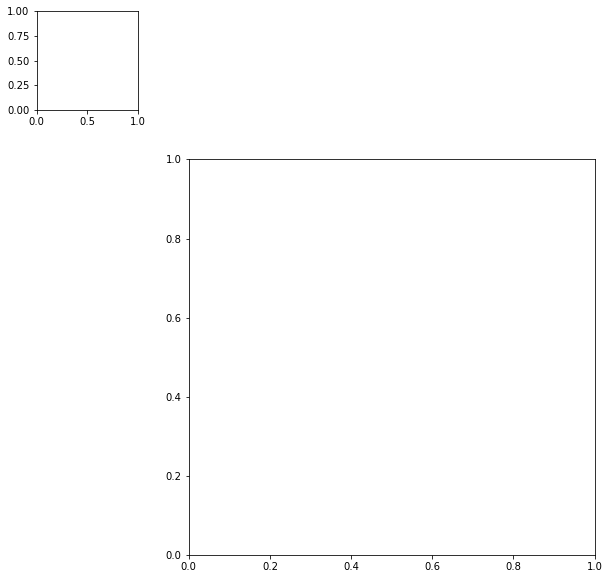

In [326]:
sns.clustermap(features, cmap='mako', yticklabels=True, standard_scale=True)
plt.show()

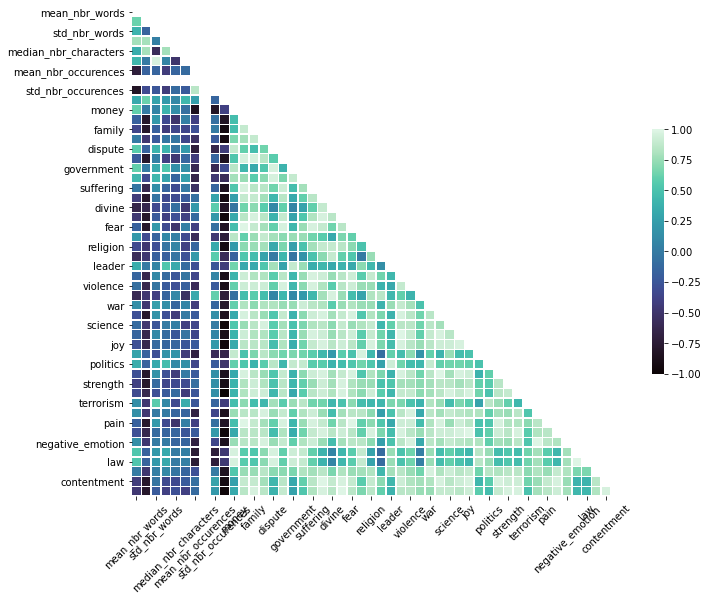

In [327]:
# Compute the correlation matrix
corr = features.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    corr, 
    mask=mask, 
    cmap='mako', 
    center=0, 
    vmin=-1, 
    vmax=1,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.xticks(rotation=45)
plt.show()

% variance explained by 2D PCA: 83.2%


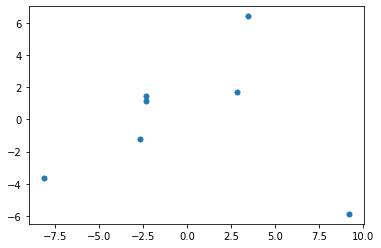

In [328]:
# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

_RANDOM_SEED = 42 # randomly fixed

# Extracting PCs that account for 95% of the variation
X_PCA95 = PCA(n_components=0.95, random_state=_RANDOM_SEED).fit_transform(X_scaled)



# PCA decomposition in 2D
pca = PCA(n_components=2, random_state=_RANDOM_SEED)
X_PCA = pca.fit_transform(X_scaled)

print(f'% variance explained by 2D PCA: {(100 * pca.explained_variance_ratio_.sum()):.1f}%')

plt.scatter(*X_PCA.T, s=25)
plt.show()

In [173]:
features.to_pickle("../data/features.pkl")

# Pre processing and extraction of the features of all speakers

In [322]:
# Data importation
Path = "../data/Pope-quotes.pkl"
file = open(Path,'rb')
df_pope = pickle.load(file)

Path = "../data/Ted_Cruz_quotes.pkl"
file = open(Path,'rb')
df_ted_cruz = pickle.load(file)

Path = "../data/Mitt_Romney_quotes.pkl"
file = open(Path,'rb')
df_mitt_romney = pickle.load(file)

Path = "../data/Mike_Pence_quotes.pkl"
file = open(Path,'rb')
df_mike_pence = pickle.load(file)

Path = "../data/Hillary_Clinton_quotes.pkl"
file = open(Path,'rb')
df_hillary_clinton = pickle.load(file)

Path = "../data/Elizabeth_Warren_quotes.pkl"
file = open(Path,'rb')
df_elizabeth_warren = pickle.load(file)

Path = "../data/Bernie_Sanders_quotes.pkl"
file = open(Path,'rb')
df_bernie_sanders = pickle.load(file)

In [323]:
# Pre processing of all the speakers dataframes

start_time = time.time()

df_pope = pre_processing(df_pope)
print("Pope finished !")
print("")
      
df_ted_cruz = pre_processing(df_ted_cruz)
print("Ted finished !")
print("")

df_mitt_romney = pre_processing(df_mitt_romney)
print("Mitt finished !")
print("")

df_mike_pence = pre_processing(df_mike_pence)
print("Mike finished !")
print("")

df_hillary_clinton = pre_processing(df_hillary_clinton)
print("Hillary finished !")
print("")

df_elizabeth_warren = pre_processing(df_elizabeth_warren)
print("Elizabeth finished !")
print("")

df_bernie_sanders = pre_processing(df_bernie_sanders)
print("Bernie finished !")

print("--- %s seconds ---" % (time.time() - start_time))

Digits removal 101 
No more punctuation !?1?
No more NaN bro
NO MORE CAPITALS
[The, quotes, are, tokenized, !]
[The, quote, be, lemmatize, !]
No more stop words !
Percentage of non english quotes that were removed : 1.19037216121484
Percentage of quotes removed (<= 50% of first probability) : 4.46243919489674
Pope finished !

Digits removal 101 
No more punctuation !?1?
No more NaN bro
NO MORE CAPITALS
[The, quotes, are, tokenized, !]
[The, quote, be, lemmatize, !]
No more stop words !
Percentage of non english quotes that were removed : 1.2634716312822618
Percentage of quotes removed (<= 50% of first probability) : 10.96736571564329
Ted finished !

Digits removal 101 
No more punctuation !?1?
No more NaN bro
NO MORE CAPITALS
[The, quotes, are, tokenized, !]
[The, quote, be, lemmatize, !]
No more stop words !
Percentage of non english quotes that were removed : 1.727699530516432
Percentage of quotes removed (<= 50% of first probability) : 12.440146465120645
Mitt finished !

Digits remo

In [324]:
# Extract features

features_pope = extract_features(df_pope)
features_ted_cruz = extract_features(df_ted_cruz)
features_mitt_romney = extract_features(df_mitt_romney)
features_mike_pence = extract_features(df_mike_pence)
features_hillary_clinton = extract_features(df_hillary_clinton)
features_elizabeth_warren = extract_features(df_elizabeth_warren)
features_bernie_sanders = extract_features(df_bernie_sanders)

features = pd.concat([features_pope, features_ted_cruz, features_mitt_romney, features_mike_pence, features_hillary_clinton, features_elizabeth_warren, features_bernie_sanders], axis=0)
features = features.reset_index(drop=True)
features

,mean_nbr_words,median_nbr_words,std_nbr_words,mean_nbr_characters,median_nbr_characters,std_nbr_characters,mean_nbr_occurences,median_nbr_occurences,std_nbr_occurences,voc_richness,money,hate,family,health,dispute,nervousness,government,swearing_terms,suffering,optimism,divine,sexual,fear,business,religion,worship,leader,death,violence,military,war,rage,science,sadness,joy,economics,politics,anger,strength,power,terrorism,poor,pain,philosophy,negative_emotion,competing,law,achievement,contentment,positive_emotion
0,22.255800,18.0,18.447044,124.638708,99.0,103.564147,7.052796,1.0,39.744323,0.319329,4750.0,6355.0,11739.0,4686.0,6408.0,4420.0,11124.0,615.0,15179.0,21359.0,23909.0,5165.0,6728.0,12017.0,22884.0,17841.0,7605.0,18970.0,12024.0,3581.0,7261.0,2732.0,3169.0,13395.0,5639.0,6371.0,7058.0,6271.0,9107.0,9544.0,3252.0,8313.0,9946.0,7804.0,15635.0,3104.0,8717.0,7553.0,6779.0,32652.0
1,23.884361,19.0,20.341421,134.057419,103.0,115.374723,5.541251,1.0,27.495870,0.590787,5117.0,2602.0,2961.0,1194.0,7509.0,688.0,15044.0,618.0,2701.0,3847.0,3608.0,716.0,1590.0,9229.0,1983.0,1719.0,9825.0,2764.0,3934.0,2829.0,7060.0,1236.0,1219.0,1857.0,660.0,5407.0,9596.0,981.0,4566.0,6984.0,3532.0,2216.0,2222.0,2507.0,8118.0,4811.0,9969.0,5287.0,625.0,6043.0
2,23.582672,19.0,19.792933,129.098434,101.0,110.834566,7.809350,1.0,36.175321,1.178640,981.0,517.0,670.0,332.0,1378.0,240.0,2441.0,101.0,498.0,1158.0,888.0,185.0,234.0,2026.0,373.0,361.0,2569.0,543.0,750.0,574.0,868.0,182.0,255.0,450.0,96.0,1267.0,1950.0,209.0,766.0,1180.0,478.0,651.0,449.0,415.0,1634.0,1088.0,1666.0,1324.0,173.0,1697.0
3,23.174990,19.0,17.244910,130.796750,107.0,98.498551,9.823270,1.0,49.972982,0.540483,4102.0,1080.0,3230.0,2111.0,5342.0,569.0,12360.0,161.0,1853.0,4955.0,4739.0,1192.0,964.0,10284.0,2616.0,2082.0,10282.0,2703.0,2730.0,4270.0,5953.0,820.0,1878.0,1781.0,711.0,5496.0,7718.0,683.0,5530.0,7336.0,3002.0,2155.0,1342.0,2645.0,4243.0,3062.0,7156.0,5936.0,676.0,8845.0
4,23.297093,18.0,20.052967,126.610468,96.0,110.226434,7.488372,1.0,33.751885,0.407549,10005.0,4496.0,6603.0,3505.0,10091.0,2991.0,18417.0,759.0,4283.0,8321.0,4338.0,1715.0,2900.0,19759.0,2288.0,1539.0,16365.0,4338.0,6976.0,3574.0,8739.0,1558.0,2985.0,3550.0,1012.0,12093.0,13537.0,1827.0,9184.0,8172.0,3688.0,5254.0,4423.0,3366.0,15548.0,7552.0,11153.0,9036.0,1776.0,12268.0
5,23.587559,19.0,18.347671,130.367006,105.0,102.413585,5.403170,1.0,21.636343,0.546310,12671.0,2027.0,3300.0,2880.0,7424.0,1057.0,13454.0,431.0,2308.0,3257.0,1520.0,984.0,1169.0,16361.0,861.0,505.0,8189.0,1485.0,5912.0,1652.0,5671.0,556.0,1807.0,1233.0,325.0,13817.0,6145.0,658.0,5310.0,7125.0,1384.0,5017.0,1898.0,1867.0,11219.0,5654.0,10024.0,4471.0,543.0,6312.0
6,24.301414,19.0,19.167566,134.209948,106.0,107.158198,5.395312,1.0,23.024088,0.354951,19593.0,4319.0,4011.0,6987.0,12045.0,2015.0,25107.0,1101.0,4611.0,5708.0,3692.0,1378.0,2303.0,27253.0,3084.0,1522.0,18694.0,4938.0,7421.0,3225.0,9767.0,1244.0,4275.0,3755.0,1116.0,24611.0,17725.0,1554.0,7380.0,8827.0,3476.0,10289.0,4011.0,5871.0,16904.0,9452.0,14799.0,10301.0,1185.0,11896.0


In [325]:
features.to_pickle("../data/features_2.pkl")

In [239]:
small_words = df_mitt_romney.loc[df_mitt_romney['quote'].str.len() <= 10]

In [280]:
df_mitt_romney['pre_processed_quote'] = df_mitt_romney['quote'].astype(str).str.replace('\d+', '', regex=True)
